In [1]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os

fs = os.listdir("..")
if not "SentEval" in fs:
    %cd ./..
    !git clone git@github.com:facebookresearch/SentEval.git
    %cd notebooks
    %mkdir data

PATH_TO_DATA = "../SentEval/data"
DEVICE = "cuda:1"

# BERT

In [2]:
def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    def __init__(self, starting_state):
        super().__init__()
        self.starting_state = starting_state

    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        emb_sum = torch.sum(x * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean

    
class Bert:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        if path is None:
            self.model = AutoModel.from_pretrained("bert-base-cased").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
    
    def prepare(self, params, samples):
        pass 
    
    @torch.no_grad()
    def batcher(self, params, batch):
        tokenized_batch = self.tokenizer(
            batch, truncation=True, padding=True, return_tensors="pt", is_split_into_words=True
        )
        batch_device = batch_to_device(tokenized_batch, DEVICE)
        out = self.model(
            **batch_device, output_hidden_states=True
        ).hidden_states[self.pooling.starting_state]
        out_mean = self.pooling(out, batch_device["attention_mask"])
        return out_mean.cpu()


In [3]:
models = [
    'model_2024_01_18_01_47', 
    'model_2024_01_18_01_48', 
    'model_2024_01_18_01_50', 
    'model_2024_01_18_01_52', 
    'model_2024_01_18_01_54', 
    'model_2024_01_18_01_56', 
    'model_2024_01_18_01_59', 
    'model_2024_01_18_02_01', 
    'model_2024_01_18_02_04', 
    'model_2024_01_18_02_07', 
    'model_2024_01_18_02_10', 
    'model_2024_01_18_02_13', 
    'model_2024_01_17_17_23'
]

In [5]:
word_content_bert = []
for i, model_path in enumerate(models):
    if i < 5:
        continue
    params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 10}
    params['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 64, 'tenacity': 5, 'epoch_size': 4}

    bert = Bert(starting_state=i, path=f"../output/bert-base-cased/mean/{i}_to_{i+1}/{model_path}.pkl")
    se = senteval.engine.SE(params, bert.batcher, bert.prepare)

    transfer_tasks = [
        'WordContent', 
    ]

    results = se.eval(transfer_tasks)
    print(results["WordContent"]["devacc"])
    word_content_bert.append(results["WordContent"]["devacc"])

72.95
68.7
68.21
66.58
62.76
57.84
56.17
57.13


13


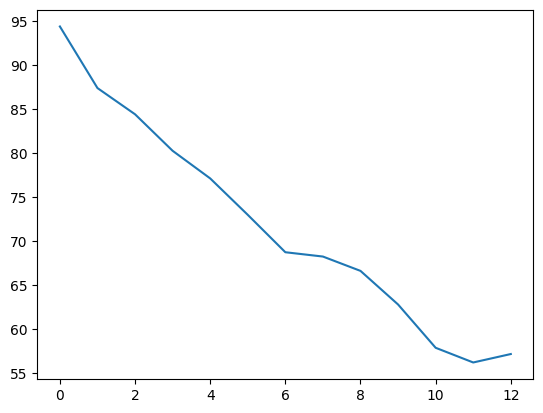

In [8]:
values = [94.36, 87.36, 84.38, 80.23, 77.09, 72.95,
68.7,
68.21,
66.58,
62.76,
57.84,
56.17,
57.13]

print(len(values))
import matplotlib.pyplot as plt
plt.plot(values)